In [ ]:
import os
import glob
import xml.etree.ElementTree as ET


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.ops import RoIAlign
from torchvision import transforms
from ultralytics import YOLO
import random
import numpy as np

In [8]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def evaluate_rank1(features, ids):
    sim_matrix = cosine_similarity(features.numpy())  # [N, N]
    num_samples = len(ids)
    correct = 0

    for i in range(num_samples):
        query_id = ids[i]
        sim_scores = sim_matrix[i]
        sim_scores[i] = -1  # exclude self-match
        top_match_idx = np.argmax(sim_scores)
        top_match_id = ids[top_match_idx]
        if top_match_id == query_id:
            correct += 1

    acc = correct / num_samples
    print(f"Rank-1 Accuracy: {acc*100:.2f}%")
    

In [9]:
from PIL import Image


class ResizePad:
    def __init__(self,size=(256,128),fill=0):
        self.target_h, self.target_w = size
        self.fill = fill
    def __call__(self,img):
        orig_w, orig_h = img.size
        scale = min(self.target_w/orig_w, self.target_h/orig_h)
        new_w, new_h = int(orig_w * scale),int(orig_h*scale)

        img = img.resize((new_w,new_h), Image.BILINEAR)

        new_img = Image.new("RGB",(self.target_w,self.target_h),(self.fill,)*3)
        paste_x = (self.target_w-new_w)//2
        paste_y = (self.target_h-new_h)//2
        new_img.paste(img,(paste_x,paste_y))

        return new_img

In [10]:
class FolderBasedReIDValidationDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform or transforms.Compose([
            ResizePad((256, 128)),
            transforms.ToTensor(),
            transforms.Normalize([0.5]*3, [0.5]*3)
        ])

        self.samples = []  # list of (image_path, person_id)

        for pid in os.listdir(root_dir):
            folder = os.path.join(root_dir, pid)
            if not os.path.isdir(folder):
                continue

            image_paths = glob.glob(os.path.join(folder, '*.png'))
            for img_path in image_paths:
                xml_path = img_path.replace('.png', '.xml')
                if os.path.exists(xml_path):  # optional check
                    self.samples.append((img_path, pid))  # folder name = pid

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        img_path, pid = self.samples[index]
        img = Image.open(img_path).convert('RGB')
        tensor = self.transform(img)
        return tensor, pid, img_path  # ⬅️ include image path

In [11]:
def compute_embeddings(model, dataloader, device):
    model.eval()
    features = []
    ids = []
    paths = []  # ⬅️ Add this

    with torch.no_grad():
        for batch in dataloader:
            if len(batch) == 2:
                imgs, pids = batch
                batch_paths = [None] * len(imgs)  # dummy placeholder
            else:
                imgs, pids, batch_paths = batch  # ⬅️ Expect 3 outputs

            imgs = imgs.to(device)
            emb = model(imgs)  # shape [B, D]
            features.append(emb.cpu())
            ids.extend(pids)
            paths.extend(batch_paths)  # ⬅️ Append actual paths

    features = torch.cat(features)
    return features, ids, paths

In [12]:
class YOLOv11ReID(nn.Module):
    def __init__(self, yolo_weights='yolo11n.pt', emb_dim=128):
        super().__init__()
        yolo_model = YOLO(yolo_weights)


        self.backbone = nn.Sequential(
          yolo_model.model.model[0],
          yolo_model.model.model[1],
          yolo_model.model.model[2],
          yolo_model.model.model[3],
          yolo_model.model.model[4],
          yolo_model.model.model[5],
          yolo_model.model.model[6],
          yolo_model.model.model[7],
          )

        
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(self._get_feat_dim(), emb_dim)

    def _get_feat_dim(self):
        x = torch.zeros((1, 3, 256, 128))
        with torch.no_grad():
            f = self.backbone(x)

            
            # f = self.pool(f).flatten(1)
            return f.shape[1]

    def forward(self, x):
        x = self.backbone(x)


        

        f = self.pool(x).flatten(1)
        pooled = self.pool(x).flatten(1)  # ✅ apply once
        emb = self.fc(pooled)
        return nn.functional.normalize(emb, dim=1)


In [20]:
device ='cuda' if torch.cuda.is_available() else 'cpu'
val_dataset = FolderBasedReIDValidationDataset(r"..\data\valid_dataset1")
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


# model = YOLOv11ReID('yolov8n.pt')  # or your trained one
# model.load_state_dict(torch.load(r"..\saved_models\reid_model_full_v0.1.pth"))
model3 = torch.load(r"..\saved_models\reid_model_fullv2.pth",map_location=torch.device('cpu'))

model3.to(device)

features, ids ,paths = compute_embeddings(model3, val_loader, device)
evaluate_rank1(features, ids)

C:\Users\USER\AppData\Local\Temp\ipykernel_161944\3387916597.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model3 = torch.load(r"..\saved_models\reid_model_fullv2.pth"

Rank-1 Accuracy: 97.60%


In [14]:
import matplotlib.pyplot as plt
def compute_similarity_gaps(features, ids,show=False):
    sim_matrix = cosine_similarity(features.numpy())  # [N, N]
    N = len(ids)
    gaps = []

    for i in range(N):
        query_id = ids[i]
        sim_scores = sim_matrix[i]

        # exclude self
        sim_scores[i] = -np.inf

        # positive scores (same ID, not self)
        pos_mask = np.array([j != i and ids[j] == query_id for j in range(N)])
        neg_mask = np.array([ids[j] != query_id for j in range(N)])

        if not np.any(pos_mask) or not np.any(neg_mask):
            continue  # skip if no pos/neg samples

        best_pos = np.max(sim_scores[pos_mask])
        best_neg = np.max(sim_scores[neg_mask])

        gap = best_pos - best_neg
        gaps.append(gap)

    gaps = np.array(gaps)
    print(f"Avg similarity gap (pos - hardest neg): {np.mean(gaps):.4f}")
    print(f"% queries where positive > negative: {(gaps > 0).mean()*100:.2f}%")
    if(show):
        # Optional: visualize
        plt.hist(gaps, bins=40, color='blue', edgecolor='black')
        plt.title("Distribution of (best positive - hardest negative) similarity gaps")
        plt.xlabel("Similarity Gap")
        plt.ylabel("Number of queries")
        plt.grid(True)
        plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_161944\1047273152.py:17: RuntimeWarning: invalid value encountered in multiply
  best_pos_idx = np.argmax(sim_scores * pos_mask)
C:\Users\USER\AppData\Local\Temp\ipykernel_161944\1047273152.py:18: RuntimeWarning: invalid value encountered in multiply
  best_neg_idx = np.argmax(sim_scores * neg_mask)
C:\Users\USER\AppData\Local\Temp\ipykernel_161944\1047273152.py:22: RuntimeWarning: invalid value encountered in scalar subtract
  gap = best_pos_sim - best_neg_sim


Avg similarity gap (pos - hardest neg): 0.1230
% queries where positive > negative: 97.60%


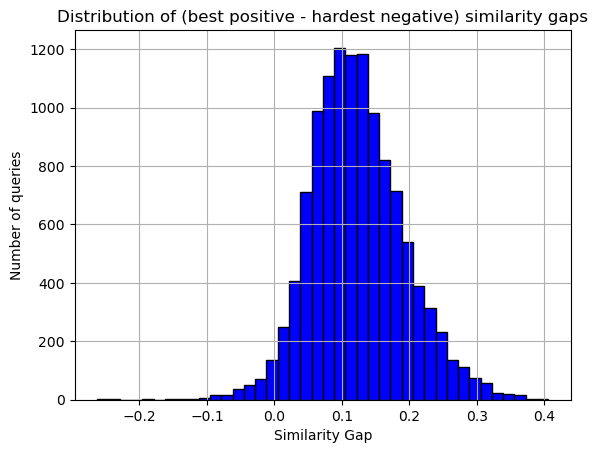

In [22]:
compute_similarity_gaps(features,ids,show=True)